# Projet Stratégies d'Investissement Alternatives et Quantitatives
## Jérémy Bellina, Joël Zhu

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Data

In [2]:
# load the crypto prices csv data
crypto_prices = pd.read_csv("crypto_prices.csv", parse_dates=[0])
crypto_prices.set_index('date', inplace=True)

# load the CRIX index csv data
crix_prices = pd.read_csv("crix.csv", parse_dates=[0]) # Usage of CRIX instead of VCRIX explained in the next cell
crix_prices.set_index('date', inplace=True)
crix_prices = crix_prices.loc["2018-04-01":"2020-05-26"]

# load the Fama & French momentum factor csv data
FFMomentum = pd.read_csv("F-F_Momentum_Factor_daily.CSV", parse_dates=[0])
FFMomentum = FFMomentum.rename(columns={'Unnamed: 0': 'date'})
FFMomentum.set_index('date', inplace=True)
FFMomentum = FFMomentum.loc["2018-04-01":]

# load the Fama & French research data factor csv data
FFResearch = pd.read_csv("F-F_Research_Data_Factors_daily.CSV", parse_dates=[0])
FFResearch = FFResearch.rename(columns={'Unnamed: 0': 'date'})
FFResearch.set_index('date', inplace=True)
FFResearch = FFResearch.loc["2018-04-01":]

Nous avons décidé d'utiliser les données du CRIX plutôt que celles du vcrix donnée dans les documents de cours car nous ne savions pas comment utilsier le vcrix qui n'est pas un indice sur les cryptomonnaies directement mais plutôt sur leur volatilité. Nous avons donc téléchargé les données du CRIX directement sur le site https://thecrix.de/.

In [3]:
formatted_dates = pd.date_range(start = "2018-04-01", end = "2020-05-26")
rebalancing_dates = pd.date_range(start = "2018-04-01", end = "2020-05-01", freq = pd.DateOffset(months=1, day=1))
horizon = 15
initial_value = 100

# Helper functions

In [4]:
def sort_returns(current_date, data):
    date = str(current_date.date())
    return data.loc[date].sort_values(ascending=False)

In [5]:
def compute_value(date, portfolio, crypto_prices):
    value = 0
    for item in portfolio:
        value += item[1] * crypto_prices.loc[date, item[0]]
    return value

In [6]:
def update_portfolio(amount, data, date, crypto_names):
    portfolio = []
    for name in crypto_names:
        portfolio.append((name, amount / data.loc[date, name]))
    return portfolio

# Backtest functions

Creates portfolio long on all crypto currencies **equally weighted**

In [7]:
def get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, data, portfolio_index):
    values = [initial_value]
    returns = data.pct_change(periods=horizon)
    portfolio = []
    for date in formatted_dates:
        if str(date) != "2018-04-01 00:00:00":
            values.append(compute_value(date, portfolio, data)) # update values
        if date in rebalancing_dates:
            sorted_returns = sort_returns(date, returns) # sort returns for the rebalancing date
            crypto_names = sorted_returns.iloc[(10 * (portfolio_index - 1)):(10 * portfolio_index)].index # extract names from data
            portfolio = update_portfolio(values[-1] / 10, data, date, crypto_names) # update composition
    return values

Creates a portfolio **long on best returns** crypto currencies and **short on lowest returns** ones

In [8]:
 def long_short_strategy(ptf_values1, ptf_values5):
    values = []
    for value1, value5 in zip(ptf_values1, ptf_values5):
        values.append(value1 - value5)
    return values

# Portfolio initializations

In [9]:
# P1, P2, P3, P4, P5
portfolios_df = pd.DataFrame()

portfolios_df["date"] = formatted_dates
portfolios_df.set_index('date', inplace=True) # set as index so that it is easier to plot

for i in range(5):
    pf_index = 1+i
    portfolios_df["P"+str(pf_index)] = get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, pf_index)

In [10]:
# Long-short strategy
ptf_values1 = get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 1)
ptf_values5 = get_portfolio_values(initial_value, horizon, formatted_dates, rebalancing_dates, crypto_prices, 5)
long_short = long_short_strategy(ptf_values1, ptf_values5)

long_short_df = pd.DataFrame(data = {'date': formatted_dates, 'P1-P5': long_short})
long_short_df.set_index('date', inplace=True)

# Plot 

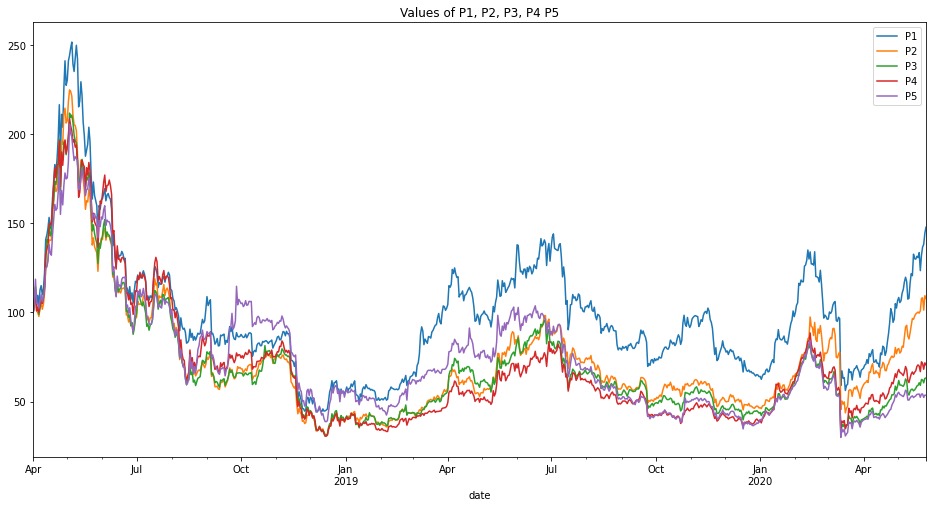

In [11]:
portfolios_df.plot(figsize=(16,8), title="Values of P1, P2, P3, P4 P5")

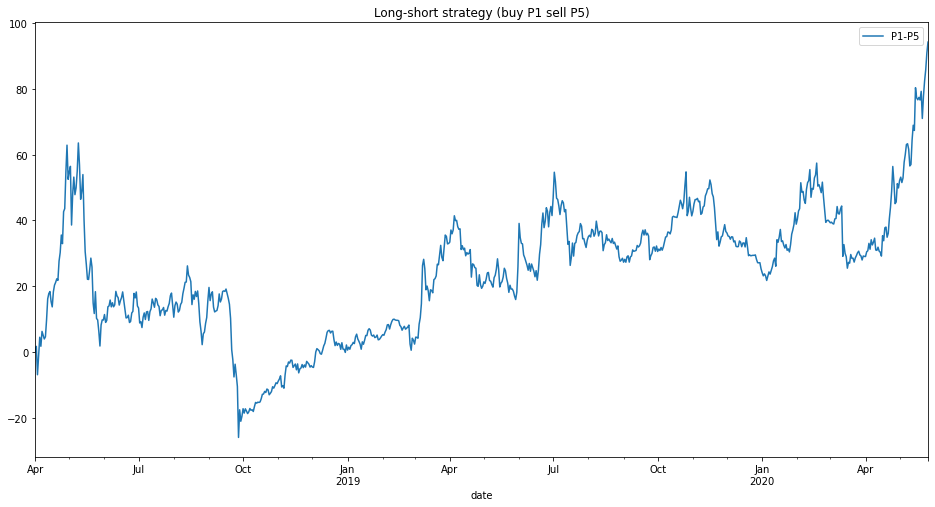

In [12]:
long_short_df.plot(figsize=(16,8), title="Long-short strategy (buy P1 sell P5)")

# Statistical description

## Initialization

In [13]:
# P1 to P5
portfolios_df_returns = portfolios_df.pct_change()


In [14]:
# Long-short strategy
long_short_df_returns = long_short_df.pct_change()

def winsorizing(df, col):
    minimum = df[col].quantile(0.03)
    maximum = df[col].quantile(0.97)
    return df.loc[(df[col] > minimum) & (df[col] < maximum)]

long_short_df_returns = winsorizing(long_short_df_returns, 'P1-P5')

## Mean

In [15]:
# P1, P2, P3, P4, P5
portfolios_df_returns.mean()

P1    0.001651
P2    0.001213
P3    0.000491
P4    0.000686
P5    0.000440
dtype: float64

Interprétation : Le rendement moyen journalier du portefeuille P1 est 0.165%. Il est plus élevé que tous les autres portefeuilles momentum. Cela est cohérent car le portefeuille P1 est constitué des crypto-monnaies ayant la plus forte croissance à chaque date de rebalancement. Il semble donc que la stratégie momentum fonctionne.

In [16]:
# Long-short strategy
long_short_df_returns.mean()

P1-P5    0.005517
dtype: float64

Interprétation : Le rendement moyen journalier de la stratégie 'acheter P1 et vendre P5' est proche de 0.5%. Cela est beaucoup plus élevé que le rendement moyen de P1. C'est un signe positif qui indique que la stratégie semble fonctionner.

## Standard deviation

In [17]:
# P1, P2, P3, P4, P5
portfolios_df_returns.std()

P1    0.047095
P2    0.046147
P3    0.045343
P4    0.046768
P5    0.048832
dtype: float64

Interprétation : Les écart-types ne sont pas significativement éloignés les uns des autres pour pouvoir dire qu'un portefeuille est plus risqué qu'un autre. On peut donc supposer que les portefeuilles de crypto-monnaies sont tous exposés à un risque de marché similaire important (celui des crypto-monnaies) mais que les portefeuilles sont suffisament diversifiés au sein de ce marché pour ne subir qu'un risque spécifique faible.

In [18]:
# Long-short strategy
long_short_df_returns.std()

P1-P5    0.133753
dtype: float64

Interprétation : L'écart-type de la stratégie est presque 2x plus élevé que le portefeuille P1. On peut donc expliquer en partie le rendement plus élevé de cet stratégie par un risque beaucoup plus grand.

## Median

In [19]:
# P1, P2, P3, P4, P5
portfolios_df_returns.median()

P1    0.003487
P2    0.002854
P3    0.002478
P4    0.003057
P5    0.003053
dtype: float64

Interprétation : Les médianes sont bien plus élevées que les moyennes. Les rendements journaliers négatifs sont donc beaucoup plus importants en valeur absolue que les rendement positifs.

In [20]:
# Long-short strategy
long_short_df_returns.median()

P1-P5    0.005484
dtype: float64

Interprétation : La médiane est plus élevée que pour le P1. Cela semble cohérent avec le fait que la rentabilité moyenne soit également plus élevée.

## Minimum

In [21]:
# P1, P2, P3, P4, P5
portfolios_df_returns.min()

P1   -0.388953
P2   -0.414802
P3   -0.398284
P4   -0.385747
P5   -0.426499
dtype: float64

Interprétation : Durant sa pire journée, le portefeuille P1 a subit une baisse de -38.90% de sa valeur. Cela est très important mais reste néanmoins légerement moins que les autres portefeuilles (à l'exception du P4).

In [22]:
# Long-short strategy
long_short_df_returns.min()

P1-P5   -0.428264
dtype: float64

Interprétation : Le minimum de la stratégie est plus faible que celui de P1. C'est un signe positif qui indique que cette stratégie permet d'amortir les variations fortes du marché. 

A noter : Ce résultat est à relativiser car on effectue une winsorisation qui élimine certaines valeurs extrêmes.

## Maximum

In [23]:
# P1, P2, P3, P4, P5
portfolios_df_returns.max()

P1    0.153043
P2    0.186089
P3    0.168602
P4    0.252157
P5    0.210899
dtype: float64

Interprétation : Durant sa meilleure journée, le portefeuille P1 a vu sa valeur monter de 15.30%. C'est impressionant mais plus faible que les autres portefeuiles qui atteignent jusqu'à 25.22%. Durant des périodes à fortes variations, le portefeuille P1 subit des gains et des pertes moins importantes que ses homologues. On pourra donc s'attendre à un Béta plus faible.

In [24]:
# Long-short strategy
long_short_df_returns.max()

P1-P5    0.524231
dtype: float64

Interprétation : Même avec la winsorisation, le maximum est nettement plus élevé que P1. C'est également un bon signe car cette stratégie permettrait donc d'amortir les variations à la baisse et amplifier les variations à la hausse.

## Skewness

In [25]:
# P1, P2, P3, P4, P5
portfolios_df_returns.skew(axis=0)

P1   -0.938847
P2   -1.129604
P3   -1.027596
P4   -0.639909
P5   -0.567365
dtype: float64

Interprétation : La skewness de tous les portefeuilles est négative. Cette statistique indique que la distribution est asymétrique et que la queue de la distribution est plus longue vers les rendements inférieurs à la moyenne. 
Pour les portefeuilles P1 à P5, la distribution est modéremment voire fortement skewed négativement.
Cela est confirmée par le fait que la moyenne soit inférieure à la médiane. 

In [26]:
# Long-short strategy
long_short_df_returns.skew(axis=0)

P1-P5    0.284883
dtype: float64

Interprétation : La skewness de la stratégie est plus proche de 0 de positive. La distribution est donc quasiment symétrique. C'est bon signe car cela signifie que la queue de la distribution est plus longue à droite de la moyenne.
Cela est également logique car la différence entre la moyenne et la médiane est plus faible pour la stratégie que pour les portefeuilles individuels.

## Kurtosis

In [27]:
# P1, P2, P3, P4, P5
portfolios_df_returns.kurtosis(axis=0)

P1    7.182078
P2    9.462124
P3    8.739581
P4    8.008115
P5    9.388953
dtype: float64

Interprétation : Les Kurtosis sont plus grandes que 3. La distribution est donc leptokurtique qui indique qu'une grande partie des rentabilités est concentrée autour de la moyenne.

In [28]:
# Long-short strategy
long_short_df_returns.kurtosis(axis=0)

P1-P5    2.503121
dtype: float64

Interprétation : Le kurtosis est inférieur à 3. La distribution est platykurtique ce qui signifie que la distribution est plate et donc les valeurs ne sont pas concentrées autour de la moyenne mais plus étalées.

## Global interpretation

La stratégie long-short qui consiste à acheter P1 et vendre P5 semble être une bonne stratégie car elle présente un bon rendement moyen et la médiane la plus élevée des portefeuilles disponibles. 

Elle est cependant beaucoup plus risquée, avec un écart-type plus fort et un kurtosis inférieur à 3 qui implique des rendements étalés et pas forcément proches de la moyenne.

Il est donc utile de réaliser des mesures de performance afin de déterminer si cette stratégie est réellement meilleure que les autres portefeuilles en calculant la rentabilité relative au risque.

De plus, on peut noter que la rentabilité dépend beaucoup des paramètres, notamment de l'horizon de calcul de la rentabilité et des dates de rebalancement.

# Performance measures

## Initialization

In [29]:
# We compute R-Rf for all portfolios
# We divide by 100 as the data is in percent.
# By using .dropna(), we only keep the dates that are common to the two dataframes.
R_RF = portfolios_df_returns.subtract(FFResearch["RF"]/100, axis = 0).dropna()
long_short_RF = long_short_df_returns.sub(FFResearch["RF"]/100, axis=0).dropna()
RM_RF = FFResearch['Mkt-RF']/100

## Sharpe

In [30]:
print(R_RF.mean()/portfolios_df_returns.std())
print(long_short_RF.mean()/long_short_df_returns.std())

P1    0.027069
P2    0.023368
P3   -0.002514
P4    0.002667
P5   -0.001956
dtype: float64
P1-P5    0.032576
dtype: float64


Interprétation: Les ratios de Sharpe sont positifs pour les portefeuilles 1, 2, 4 et la stratégie long-short. Etant donné que ces ratios sont entre 0 et 1, cela indique que la rentabilité supplémentaire dégagée par ces portefeuilles est dûe à une prise de risque très élevée par rapport au titre sans risque.

On peut cependant voir que le ratio de la stratégie long-short est plus élevée que celui du portefeuille P1 qui est lui-même plus élevé que le reste. Ainsi, à risque égal, le rendement de la stratégie est plus important que le rendement des portefeuilles individuels. 

Néanmoins, la différence n'est pas très grande malgré le fait que le rendement moyen de la stratégie soit bien plus grande que celui de P1, ceci s'explique par le fait que le risque de la stratégie est également beaucoup plus élevé que celui du portefeuille P1.

## Treynor et Jensen

### Regressions

In [31]:
intercept = sm.add_constant(RM_RF)
reg1 = sm.OLS(R_RF["P1"], intercept).fit()
reg2 = sm.OLS(R_RF["P2"], intercept).fit()
reg3 = sm.OLS(R_RF["P3"], intercept).fit()
reg4 = sm.OLS(R_RF["P4"], intercept).fit()
reg5 = sm.OLS(R_RF["P5"], intercept).fit()

print(reg1.summary())
print(reg2.summary())
print(reg3.summary())
print(reg4.summary())
print(reg5.summary())

                            OLS Regression Results                            
Dep. Variable:                     P1   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     35.04
Date:                Fri, 12 Mar 2021   Prob (F-statistic):           5.86e-09
Time:                        11:28:19   Log-Likelihood:                 832.86
No. Observations:                 525   AIC:                            -1662.
Df Residuals:                     523   BIC:                            -1653.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.484      0.6

Interprétation:
- Les valeurs de R² des cinq régressions sont entre 5% et 7%, cela signifie que le modèle que nous utilisons ne permet pas d'expliquer toute la variance de R_Rf autour de sa moyenne. Elle en explique même très peu : moins de 10%. Ceci n'est pas étonnant car nous savons que le modèle CAPM à lui seul n'est pas suffisant pour expliquer l'entièreté de la rentabilité des actifs. En effet, il existe aujourd'hui un phénomène de "zoo de facteurs" où, les professionnels et chercheurs essaient de trouver de plus en plus de facteurs étant correlés avec la rentabilité.

- Aucune des valeurs des alphas de Jensen ne sont significativement différents de 0. Ces valeurs ne sont donc pas interprétables. Ce n'est pas étonnant que les alphas ne soient pas significativement différents de 0 car notre stratégie consiste à faire du Market-timing et le portefeuille change régulièrement de composition au cours de sa période d'estimation. On sait que lorsqu'on fait du Market-timing, le alpha de Jensen sera inutilisable.

- Tous les bêtas (coefficient de Mkt-Rf) ont des p-values de très proches de 0, donc les bêtas sont significativement différents de 0. Nous pouvons donc utiliser ces valeurs afin de calculer le ratio de Treynor des portefeuilles
Les bétas étant tous compris entre 0 et 1, cela indique que les valeurs des portefeuilles amortissent celles du marché.

### Treynor

In [32]:
# treynor
trey1 = R_RF["P1"].mean()/reg1.params['Mkt-RF']
trey2 = R_RF["P2"].mean()/reg2.params['Mkt-RF']
trey3 = R_RF["P3"].mean()/reg3.params['Mkt-RF']
trey4 = R_RF["P4"].mean()/reg4.params['Mkt-RF']
trey5 = R_RF["P5"].mean()/reg5.params['Mkt-RF']

print("P1: " + str(trey1))
print("P2: " + str(trey2))
print("P3: " + str(trey3))
print("P4: " + str(trey4))
print("P5: " + str(trey5))

P1: 0.0015672539748178506
P2: 0.0014169651241236192
P3: -0.00014952162759545974
P4: 0.0001476956778593596
P5: -0.00012612475971423456


Interprétation: Nous pouvons voir que les ratios de Treynor des portefeuilles 1, 2 et 4 sont positifs tandis que ceux des portefeuilles 3 et 5 sont négatifs. Ce ratio indique l'excès de rendement par unité de risque pris. Le ratio pour P1 est plus élevé que le reste, ce qui est positif. Néanmoins, tous ces ratios sont très proches de 0, ce qui signifie que l'excès de rendement par rapport au risque est très faible.

### P1-5

In [33]:
# We change the intercept to fit the dates
intercept_ls = sm.add_constant(RM_RF[long_short_RF.index])
reg_ls = sm.OLS(long_short_RF, intercept_ls).fit()
reg_ls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  P1-P5   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     4.760
Date:                Fri, 12 Mar 2021   Prob (F-statistic):             0.0296
Time:                        11:28:20   Log-Likelihood:                 270.43
No. Observations:                 489   AIC:                            -536.9
Df Residuals:                     487   BIC:                            -528.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.006      0.644      0.520      -0.008       0.016
Mkt-RF         0.8713      0.399      2.182      0.030       0.087       1.656
==============================================================================
Omnibus:                       36.635   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.767
Skew:                           0.280   Prob(JB):                     1.98e-25
Kurtosis:                       5.296   Cond. No.                         63.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interprétation: 
- La valeur de R² est de l'ordre de 1%, ce qui signifie que la variance des rendements du portefeuille 1-5 n'est que très faiblement expliquée par notre modèle. Cela est cohérent avec le fait que la variance des rendements de ce portefeuille est plus élevée que pour les autres portefeuilles et aussi le fait que le kurtosis des rendements est inférieur à 3. De plus, la constitution de ce portefeuille sur sa durée de vie est plus complexe.

- La valeur du alpha n'est pas significativement différente de 0, il n'est donc pas interprétable.

- La valeur de bêta est significativement différente de 0, on peut donc utiliser sa valeur afin de calculer le ratio de Treynor. Le béta est plutôt similaire aux portefeuilles P1 à P5.

In [34]:
# treynor
long_short_RF.mean()/reg_ls.params['Mkt-RF']

P1-P5    0.005001
dtype: float64

Interprétation: Le ratio de Treynor de la stratégie est le plus élevé que tous les portefeuilles. Il présente donc une meilleure rentabilité par unité de risque que les portefeuilles. Ce qui semble cohérent avec les autres statistiques qu'on a vu précédemment.

## Fama et French

### Portefeuilles 1 à 5

In [35]:
intercept_ff = sm.add_constant(FFResearch[["Mkt-RF", "SMB", "HML"]]/100)

reg_ff1 = sm.OLS(R_RF["P1"], intercept_ff).fit()
reg_ff2 = sm.OLS(R_RF["P2"], intercept_ff).fit()
reg_ff3 = sm.OLS(R_RF["P3"], intercept_ff).fit()
reg_ff4 = sm.OLS(R_RF["P4"], intercept_ff).fit()
reg_ff5 = sm.OLS(R_RF["P5"], intercept_ff).fit()

print(reg_ff1.summary())
print(reg_ff2.summary())
print(reg_ff3.summary())
print(reg_ff4.summary())
print(reg_ff5.summary())

                            OLS Regression Results                            
Dep. Variable:                     P1   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     12.68
Date:                Fri, 12 Mar 2021   Prob (F-statistic):           5.18e-08
Time:                        11:28:20   Log-Likelihood:                 834.34
No. Observations:                 525   AIC:                            -1661.
Df Residuals:                     521   BIC:                            -1644.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.427      0.6

Interprétation: 
- Les valeurs de R² sont de nouveau de l'ordre de 5 à 8%, ce qui signifie que notre nouveau modèle n'explique pas beaucoup plus de la variance de R_Rf que le modèle précédent. C'est surprenant car on pourrait être amené à penser qu'avec plus de facteurs, on peut mieux expliquer la variance.

- Tous les $\beta_M$ sont de nouveau significativement différents de 0.

- Tous les $\beta_{HML}$ ne sont pas significativement différents de 0, les rentabilités des portefeuilles ne sont donc pas explicables grâce au coefficient HML.

- Le $\beta_{SMB}$ est significativement différent de 0 à 5% pour P5 et à 10% pour P2, néanmoins tous les autres ne le sont pas. Pour les portefeuilles dont le $\beta_{SMB}$ est significativement différent de 0, le R² n'est pas forcément plus grand qu'avec seulement le $\beta_{M}$, donc l'apport de ce coefficient n'es tpas très important.

### Portefeuille 1-5

In [36]:
FFResearch_adapted_long_short = pd.merge(long_short_RF, FFResearch[["Mkt-RF", "SMB", "HML"]]/100, left_index=True, right_index=True)
intercept_ff1_5 = sm.add_constant(FFResearch_adapted_long_short[["Mkt-RF", "SMB", "HML"]])
reg_ff1_5 = sm.OLS(FFResearch_adapted_long_short["P1-P5"], intercept_ff1_5).fit()
reg_ff1_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  P1-P5   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.851
Date:                Fri, 12 Mar 2021   Prob (F-statistic):              0.137
Time:                        11:28:20   Log-Likelihood:                 270.83
No. Observations:                 489   AIC:                            -533.7
Df Residuals:                     485   BIC:                            -516.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.006      0.551      0.582      -0.009       0.016
Mkt-RF         0.9455      0.410      2.304      0.022       0.139       1.752
SMB            0.2430      0.976      0.249      0.803      -1.674       2.160
HML           -0.6921      0.786     -0.881      0.379      -2.236       0.852
==============================================================================
Omnibus:                       36.374   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.406
Skew:                           0.274   Prob(JB):                     2.37e-25
Kurtosis:                       5.295   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interprétation: La R² est très faible de nouveau, donc notre modèle n'explique pas toute la variance des données. De plus seul le $\beta_M$ est significativement différent de 0.

# Carhart

In [37]:
# We use merge in order to keep only the dates present in both dataframes
R_RF_and_FFResearch_merged = pd.merge(R_RF, FFResearch/100, left_index=True, right_index=True)
final_merge = pd.merge(R_RF_and_FFResearch_merged, FFMomentum/100, left_index=True, right_index=True)

intercept_c = sm.add_constant(final_merge[['Mom   ', 'Mkt-RF', 'SMB', 'HML']])

reg_c1 = sm.OLS(final_merge["P1"], intercept_c).fit()
reg_c2 = sm.OLS(final_merge["P2"], intercept_c).fit()
reg_c3 = sm.OLS(final_merge["P3"], intercept_c).fit()
reg_c4 = sm.OLS(final_merge["P4"], intercept_c).fit()
reg_c5 = sm.OLS(final_merge["P5"], intercept_c).fit()

print(reg_c1.summary())
print(reg_c2.summary())
print(reg_c3.summary())
print(reg_c4.summary())
print(reg_c5.summary())

                            OLS Regression Results                            
Dep. Variable:                     P1   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     9.693
Date:                Fri, 12 Mar 2021   Prob (F-statistic):           1.44e-07
Time:                        11:28:20   Log-Likelihood:                 834.71
No. Observations:                 525   AIC:                            -1659.
Df Residuals:                     520   BIC:                            -1638.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.481      0.6

Interprétation:
- Pour calculer le facteur UMD, nous avons décidé de prendre les valeurs présentes dans le fichier FF-Momentum fourni. On aurait pu également utiliser les rendements de la stratégie long-short directement.

- Une fois de plus, les valeurs de R² n'ont pas l'air d'avoir beaucoup changé. Ils restent entre 5% et 8%. 

- Tous les $\beta_{UMD}$ sont significativement différents de 0, ce qui signifie que les rendements des portefeuilles sont expliqués en partie par le coefficient P1-P5 ou UMD.

- Seuls les $\beta_{M}$ sont significativement différents de 0. Le reste est ininterprétable.

In [38]:
long_short_RF_and_long_short_merged = pd.merge(long_short_RF, FFResearch/100, left_index=True, right_index=True)
final_merge2 = pd.merge(long_short_RF_and_long_short_merged, FFMomentum/100, left_index=True, right_index=True)

intercept_c_ls = sm.add_constant(final_merge2[['Mom   ', 'Mkt-RF', 'SMB', 'HML']])

reg_c_ls = sm.OLS(final_merge2["P1-P5"], intercept_c_ls).fit()

reg_c_ls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  P1-P5   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.527
Date:                Fri, 12 Mar 2021   Prob (F-statistic):              0.193
Time:                        11:28:20   Log-Likelihood:                 271.11
No. Observations:                 489   AIC:                            -532.2
Df Residuals:                     484   BIC:                            -511.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.006      0.501      0.617      -0.009       0.016
Mom           -0.6839      0.915     -0.747      0.455      -2.483       1.115
Mkt-RF         0.9817      0.413      2.375      0.018       0.170       1.794
SMB            0.0661      1.005      0.066      0.948      -1.908       2.040
HML           -1.1591      1.005     -1.154      0.249      -3.133       0.815
==============================================================================
Omnibus:                       36.426   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.520
Skew:                           0.279   Prob(JB):                     3.69e-25
Kurtosis:                       5.283   Cond. No.                         199.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interprétation :

- On rencontre les mêmes problèmes d'interprétation avec la stratégie long-short qu'avec les portefeuilles individuels. On peut cependant remarquer que le béta est très proche de 1, ce qui indique que les variations de cette stratégie sont très similaires aux variations du marché.

## Global interpretation

Sachant que notre stratégie est semblable à du market timing, nous aurions pu faire des regressions sur les périodes pendant lesquels les portefeuilles n'étaient pas rebalancés, c'est-à-dire des périodes de un mois afin d'estimer les bêtas et les alphas sur ces plus courtes périodes et potentiellement obtenir des valeurs, notamment pour alpha, significativement différent de 0.

Néanmoins, nous voyons que, rapporté à son risque, aucune des stratégies précédentes ne surperforme réellement le sans-risque. En effet, aucun des ratios de Sharpe ni de Treynor ne sont supérieurs à 1 et aucun alpha n'est sgnificativement différent de 0. Nous n'avons donc pas jugé utile de réaliser beaucoup plus d'analyses statistiques sur ces données.

# CRIX

# Initialization

In [39]:
crix_prices_returns = crix_prices.pct_change()
crix_RF = crix_prices_returns.subtract(FFResearch["RF"]/100, axis = 0).dropna()

# Treynor et Jensen

## Regressions

In [40]:
intercept_crix = sm.add_constant(crix_RF)

reg_crix1 = sm.OLS(R_RF["P1"], intercept_crix).fit()
reg_crix2 = sm.OLS(R_RF["P2"], intercept_crix).fit()
reg_crix3 = sm.OLS(R_RF["P3"], intercept_crix).fit()
reg_crix4 = sm.OLS(R_RF["P4"], intercept_crix).fit()
reg_crix5 = sm.OLS(R_RF["P5"], intercept_crix).fit()

print(reg_crix1.summary())
print(reg_crix2.summary())
print(reg_crix3.summary())
print(reg_crix4.summary())
print(reg_crix5.summary())

                            OLS Regression Results                            
Dep. Variable:                     P1   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     14.57
Date:                Fri, 12 Mar 2021   Prob (F-statistic):           0.000152
Time:                        11:28:20   Log-Likelihood:                 823.05
No. Observations:                 525   AIC:                            -1642.
Df Residuals:                     523   BIC:                            -1634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.509      0.6

Interprétation :

- La valeur du R² est de l'ordre de 1%, ce qui est beaucoup plus faible que lors de la régression avec seulement le paramètre Mkt-Rf. On explique donc encore moins la variance en utilisant le CRIX qu'avec les données Mkt-Rf fournies. Cela pourrait être dû au fait que les cryptomonnaies sont totalement décentralisées et dérégularisées, et que donc rapporter cet indice à un taux sans risque a peu de sens car sa valeur est pour l'instant, purement spéculative.

- Avec la regression sur les valeurs des rendements du CRIX, les alphas ne sont toujours pas significativement différents de 0. Néanmoins de la même façon que précédemment, les bêtas le sont et on remarque qu'ils sont tous négatifs. Cela signifie que les 5 portefeuilles vont en moyenne à contresens du CRIX, lorsque celui-ci baisse, nos portefeuilles vont monter et quand le CRIX monte, nos portefeuilles vont avoir tendance à baisser.

- Le portefeuille P1 est le plus fortement négatif, ce qui signifie qu'il est celui qui se comporte le plus comme une valeur refuge dans le cas où le marché baisse.

## Treynor

In [41]:
trey_crix1 = R_RF["P1"].mean()/reg_crix1.params['price']
trey_crix2 = R_RF["P2"].mean()/reg_crix2.params['price']
trey_crix3 = R_RF["P3"].mean()/reg_crix3.params['price']
trey_crix4 = R_RF["P4"].mean()/reg_crix4.params['price']
trey_crix5 = R_RF["P5"].mean()/reg_crix5.params['price']

print("P1: " + str(trey_crix1))
print("P2: " + str(trey_crix2))
print("P3: " + str(trey_crix3))
print("P4: " + str(trey_crix4))
print("P5: " + str(trey_crix5))

P1: -0.006463659645597248
P2: -0.007801150599284481
P3: 0.0008138237226066562
P4: -0.0009429690715240608
P5: 0.0006249088481287904


Interprétation : 
- Les ratios de Treynor sont du même ordre de grandeur que ceux avec Mkt-Rf, néanmoins ici le premier portefeuille a un ratio négatif, cela vient notamment du fait que son beta est négatif.

## P1-5

In [42]:
# We change the intercept to fit the dates
ls_crix_merged = pd.merge(long_short_RF, crix_RF, left_index=True, right_index=True)

intercept_ls_crix = sm.add_constant(ls_crix_merged["price"])
reg_ls_crix = sm.OLS(ls_crix_merged["P1-P5"], intercept_ls_crix).fit()
reg_ls_crix.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  P1-P5   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.888
Date:                Fri, 12 Mar 2021   Prob (F-statistic):             0.0899
Time:                        11:28:20   Log-Likelihood:                 269.49
No. Observations:                 489   AIC:                            -535.0
Df Residuals:                     487   BIC:                            -526.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.006      0.689      0.491      -0.008       0.017
price         -0.2540      0.149     -1.699      0.090      -0.548       0.040
==============================================================================
Omnibus:                       33.087   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.558
Skew:                           0.236   Prob(JB):                     1.46e-22
Kurtosis:                       5.171   Cond. No.                         23.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interprétation: 
- La valeur de R² est de l'ordre de 0.5%, ce qui est beaucoup trop faible pour pouvoir considérer que le modèle explique bien les variations de la stratégie long-short
- Nous avons de nouveau un beta négatif, néanmoins il n'est sgnificativement différent de 0 qu'à 90%, ce qui laisse présager que toute interprétation pourrait conduire à de nombreuses erreurs

In [43]:
# treynor
long_short_RF.mean()/reg_ls_crix.params['price']

P1-P5   -0.017154
dtype: float64

Interprétation: Nous avons calculé la valeur du Treynor, qui est négatif, même si celui-ci ne soit pas vraiment interprétable au vu des résultats de la régression.

# Fama-French

## P1 à P5

In [44]:
FFResearch_crix_merged = pd.merge(FFResearch, crix_RF*100, left_index=True, right_index=True)

intercept_ff_crix = sm.add_constant(FFResearch_crix_merged[["price", "SMB", "HML"]]/100)

reg_ff_crix1 = sm.OLS(R_RF["P1"], intercept_ff_crix).fit()
reg_ff_crix2 = sm.OLS(R_RF["P2"], intercept_ff_crix).fit()
reg_ff_crix3 = sm.OLS(R_RF["P3"], intercept_ff_crix).fit()
reg_ff_crix4 = sm.OLS(R_RF["P4"], intercept_ff_crix).fit()
reg_ff_crix5 = sm.OLS(R_RF["P5"], intercept_ff_crix).fit()

print(reg_ff_crix1.summary())
print(reg_ff_crix2.summary())
print(reg_ff_crix3.summary())
print(reg_ff_crix4.summary())
print(reg_ff_crix5.summary())

                            OLS Regression Results                            
Dep. Variable:                     P1   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     5.894
Date:                Fri, 12 Mar 2021   Prob (F-statistic):           0.000584
Time:                        11:28:20   Log-Likelihood:                 824.60
No. Observations:                 525   AIC:                            -1641.
Df Residuals:                     521   BIC:                            -1624.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.576      0.5

Interprétation : 
- Toutes les valeurs de R² sont inférieures à 5%
- Tout comme pour le Fama et French avec Mkt-Rf, seul $\beta_{Crix}$ est utilisable. Parfois le $\beta_{Crix}$ l'est aussi.

## P1-P5

In [45]:
FFResearch_ls_crix = pd.merge(long_short_RF, FFResearch_crix_merged/100, left_index=True, right_index=True)
intercept_ff_crix1_5 = sm.add_constant(FFResearch_ls_crix[["price", "SMB", "HML"]])
reg_ff_crix1_5 = sm.OLS(FFResearch_ls_crix["P1-P5"], intercept_ff_crix1_5).fit()
reg_ff_crix1_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  P1-P5   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.059
Date:                Fri, 12 Mar 2021   Prob (F-statistic):              0.366
Time:                        11:28:20   Log-Likelihood:                 269.65
No. Observations:                 489   AIC:                            -531.3
Df Residuals:                     485   BIC:                            -514.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.006      0.657      0.511      -0.008       0.017
price         -0.2567      0.150     -1.713      0.087      -0.551       0.038
SMB            0.3925      0.978      0.401      0.688      -1.529       2.315
HML           -0.3158      0.769     -0.411      0.682      -1.827       1.196
==============================================================================
Omnibus:                       32.697   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.028
Skew:                           0.231   Prob(JB):                     3.14e-22
Kurtosis:                       5.156   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interprétation : 
- Le R² est sous 1%
- Aucun des paramètres n'est significativement différent de 0 à 5£ d'erreur

# Carthart

In [46]:
final_merge_crix = pd.merge(R_RF, FFResearch_crix_merged, left_index=True, right_index=True)
final_merge_crix = pd.merge(FFMomentum, final_merge_crix, left_index=True, right_index=True)

intercept_c_crix = sm.add_constant(final_merge_crix[['Mom   ', 'price', 'SMB', 'HML']])

reg_c_crix1 = sm.OLS(final_merge_crix["P1"], intercept_c_crix).fit()
reg_c_crix2 = sm.OLS(final_merge_crix["P2"], intercept_c_crix).fit()
reg_c_crix3 = sm.OLS(final_merge_crix["P3"], intercept_c_crix).fit()
reg_c_crix4 = sm.OLS(final_merge_crix["P4"], intercept_c_crix).fit()
reg_c_crix5 = sm.OLS(final_merge_crix["P5"], intercept_c_crix).fit()

print(reg_c_crix1.summary())
print(reg_c_crix2.summary())
print(reg_c_crix3.summary())
print(reg_c_crix4.summary())
print(reg_c_crix5.summary())

                            OLS Regression Results                            
Dep. Variable:                     P1   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     4.699
Date:                Fri, 12 Mar 2021   Prob (F-statistic):           0.000985
Time:                        11:28:20   Log-Likelihood:                 825.16
No. Observations:                 525   AIC:                            -1640.
Df Residuals:                     520   BIC:                            -1619.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.639      0.5

Interprétation : 
- Les R² restent très très faibles
- Les $\beta_{SMB}$ et $\beta_{Crix}$ sont utilisables

# Changing horizon

In [47]:
changed_horizon = 14

## Initialization

In [48]:
# P1, P2, P3, P4, P5
portfolios_df = pd.DataFrame()

portfolios_df["date"] = formatted_dates
portfolios_df.set_index('date', inplace=True) # set as index so that it is easier to plot

for i in range(5):
    pf_index = 1+i
    portfolios_df["P"+str(pf_index)] = get_portfolio_values(initial_value, changed_horizon, formatted_dates, rebalancing_dates, crypto_prices, pf_index)

In [49]:
# Long-short strategy
ptf_values1 = get_portfolio_values(initial_value, changed_horizon, formatted_dates, rebalancing_dates, crypto_prices, 1)
ptf_values5 = get_portfolio_values(initial_value, changed_horizon, formatted_dates, rebalancing_dates, crypto_prices, 5)
long_short = long_short_strategy(ptf_values1, ptf_values5)

long_short_df = pd.DataFrame(data = {'date': formatted_dates, 'P1-P5': long_short})
long_short_df.set_index('date', inplace=True)

## Plot

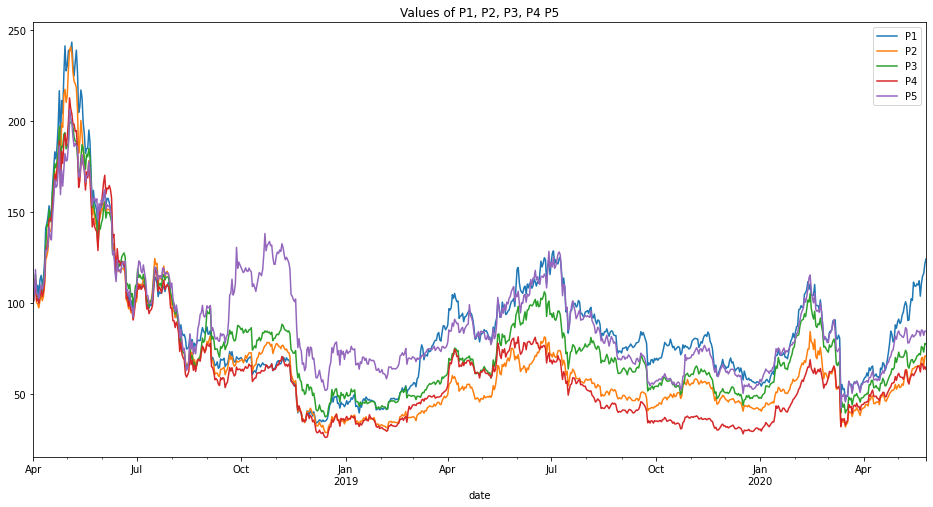

In [50]:
portfolios_df.plot(figsize=(16,8), title="Values of P1, P2, P3, P4 P5")

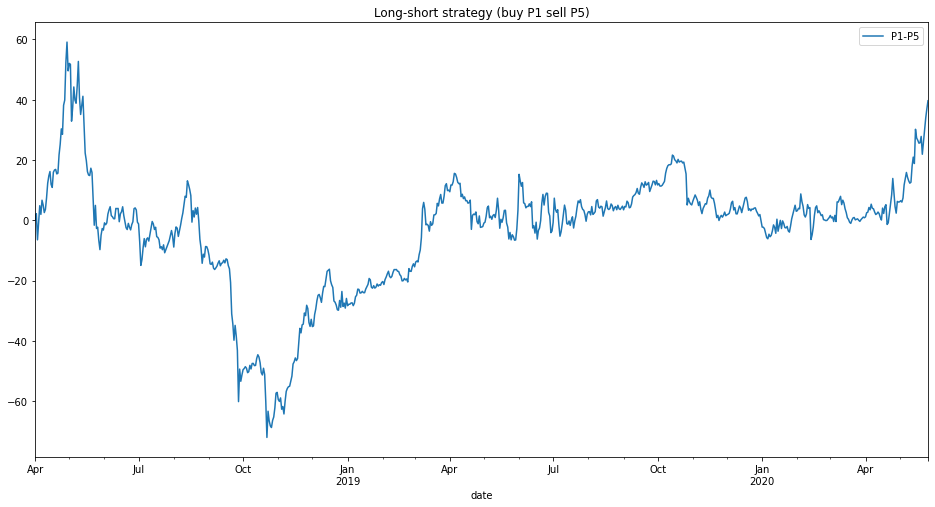

In [51]:
long_short_df.plot(figsize=(16,8), title="Long-short strategy (buy P1 sell P5)")

Interprétation :

- On peut observer de façon succincte que rien qu'en changeant l'horizon sur lequel on calcule la rentabilité d'une unité, en passant de 15 à 14, les portefeuilles sont vastement différents. La stratégie momentum ne semble plus fonctionner car les rentabilités des portefeuilles P1 à P5 ne sont plus croissants. En effet, le portefeuille P5 semble ici être le plus performant. 

- On peut par ailleurs voir que la stratégie long_short a une rentabilité majoritairement négative sur la période.

- On conclut que l'horizon des rentabilités ainsi que les dates de rebalancement ont un grand impact sur la rentabilité de la stratégie momentum. Avec un horizon correctement choisi et un market timing fin, il est possible de constituer un portefeuille dégageant une grande rentabilité, mais en se trompant légèrement, on peut avoir une mauvaise performance. Le défi pour un gérant de portefeuille est alors de trouver des moyens de calculer un horizon et de déterminer les bonnes dates de rebalancement afin de pouvoir trouver le bon portefeuille à constituer.